In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [3]:
model_df = pd.read_pickle('model_output.pkl')
agent_df = pd.read_pickle('agent_output.pkl')
joint_calendar_df = pd.read_pickle('joint_calendar.pkl')

In [4]:
# Reset indices - should have been done before export - necessary for join, df math, etc
# See next block for agent_df which has a multi index and is trickier
model_df = model_df.reset_index(drop=True)
joint_calendar_df = joint_calendar_df.reset_index(drop=True)


In [5]:
# Reset index and move it to columns
agent_df = agent_df.reset_index()

# Subtract 52 from 'Step' column to start from 0
agent_df['Step'] = agent_df['Step'] - 52

# Set 'Step' and 'AgentID' back as indices
agent_df.set_index(['Step', 'AgentID'], inplace=True)

In [6]:
# Reset index and move it to columns
agent_df_reset = agent_df.reset_index()

# Create a date range starting from '2021-01-03' with a frequency of one week
# The number of periods is the number of unique 'Step' values in agent_df
dates = pd.date_range(start='2021-01-03', periods=agent_df_reset['Step'].nunique(), freq='W')

# Create a DataFrame mapping 'Step' to 'Date'
step_to_date = pd.DataFrame({'Step': range(0, len(dates)), 'Date': dates})

# Merge this DataFrame with agent_df to add the 'Date' column
agent_df_reset = agent_df_reset.merge(step_to_date, on='Step')

# Set 'Step' and 'AgentID' back as indices
agent_df = agent_df_reset.set_index(['Step', 'AgentID'])

In [7]:

def calculate_total_purchases(agent_df):
    '''
    Computes total purchases per brand per step from agent level output
    Used as sanity check for model level output
    '''
    # Initialize empty lists to store the results
    total_purchases_A = []
    total_purchases_B = []
    dates = []
    steps = []

    # Iterate over the 'Purchased_This_Step' column
    for index, row in agent_df.iterrows():
        # Append the number of purchases for each brand to the respective list
        total_purchases_A.append(row['Purchased_This_Step']['A'])
        total_purchases_B.append(row['Purchased_This_Step']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the total purchases for each brand
    total_purchases_df = pd.DataFrame({
        'Total_Purchases_A': total_purchases_A,
        'Total_Purchases_B': total_purchases_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and sum the purchases
    total_purchases_df = total_purchases_df.groupby(['Date']).sum().reset_index()

    return total_purchases_df

In [8]:
total_purchases_df = calculate_total_purchases(agent_df)

In [9]:
# Calculate total dollar sales for Brand A and Brand B and add them to the model_df
model_df['Total_Sales_A'] = model_df['Total_Purchases_A'] * joint_calendar_df[('A', 'price')]
model_df['Total_Sales_B'] = model_df['Total_Purchases_B'] * joint_calendar_df[('B', 'price')]

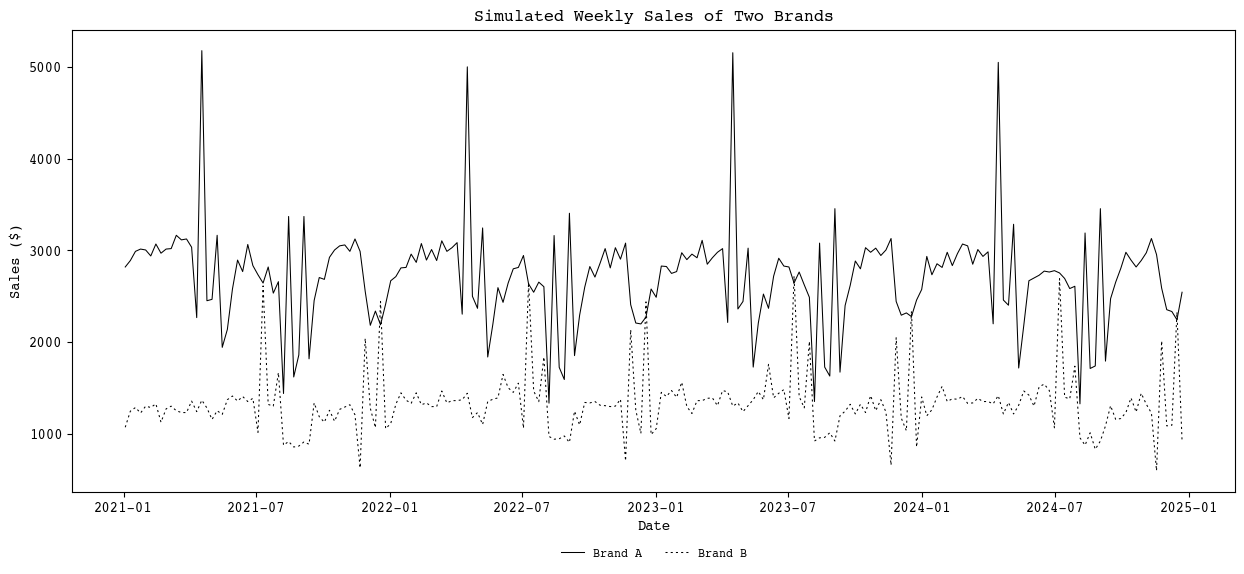

In [10]:
# Create the plot
plt.figure(figsize=(15,6))

plt.plot(model_df['Date'], model_df['Total_Sales_A'], label='Brand A', color='black')
plt.plot(model_df['Date'], model_df['Total_Sales_B'], label='Brand B', color='black', linestyle='--', dashes=[2,3])

plt.title('Simulated Weekly Sales of Two Brands')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.savefig("testfig.png", dpi=200)
plt.show()


In [11]:
# Calculate total dollar sales for Brand A and Brand B and add them to the model_df
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Purchases_A'] * joint_calendar_df[('A', 'price')]
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Purchases_B'] * joint_calendar_df[('B', 'price')]

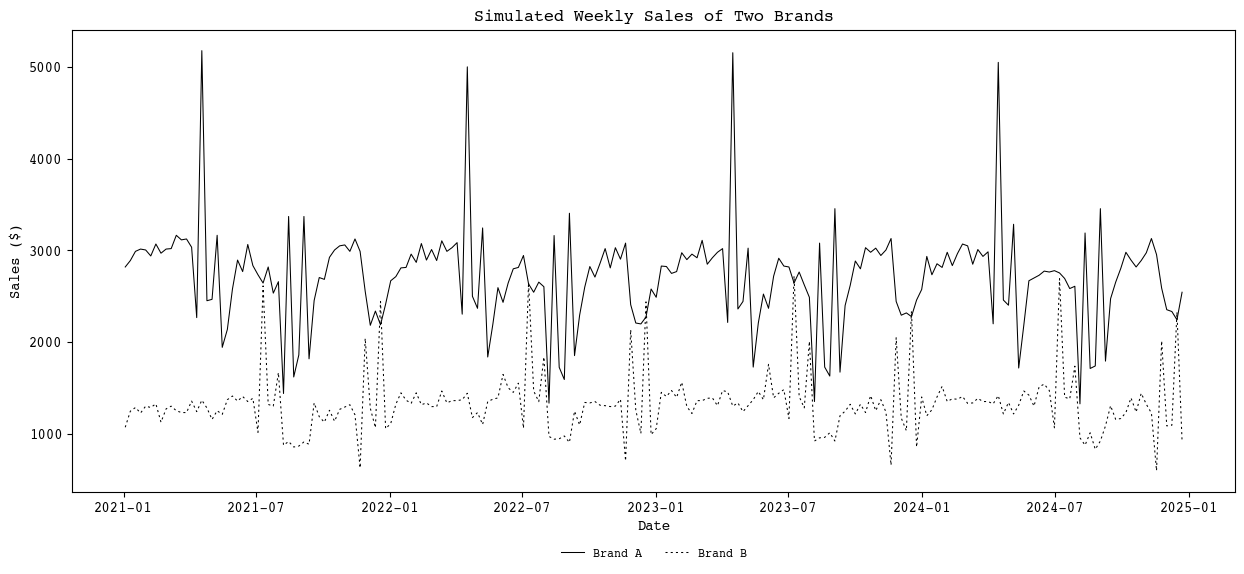

In [12]:
# Create the plot
plt.figure(figsize=(15,6))

plt.plot(total_purchases_df['Date'], total_purchases_df['Total_Sales_A'], label='Brand A', color='black')
plt.plot(total_purchases_df['Date'], total_purchases_df['Total_Sales_B'], label='Brand B', color='black', linestyle='--', dashes=[2,3])

plt.title('Simulated Weekly Sales of Two Brands')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, fontsize='small', frameon=False)

plt.savefig("testfig.png", dpi=200)
plt.show()